# Benchmarking nctoolkit and xarray for basic manipulation of netCDF files


This notebook compares the performance of nctoolkit and xarray for basic manipulation of netCDF files.
It uses the same data file that is used throughout the nctoolkit documentation. 
This is the NOAA COBE2 sea surface temperature dataset, which is a degree global grid of monthly sea surface temperature data from 1982 to 2013. This can be download from the NOAA website here: https://psl.noaa.gov/data/gridded/data.cobe2.html or using wget with the following command:

In [1]:
# ! wget https://downloads.psl.noaa.gov/Datasets/COBE2/sst.mon.mean.nc

## Approach to benchmarking

The file size used is 504 MB. 

The following operations are benchmarked:

1. Calculating a temporal average
2. Calculating an annual average
3. Calculating a monthly climatology
4. Calculating a spatial average
5. Calculating a rolling average

A simple post-processing chain is simulated where a file is read in and a new file is written out. In each case the input file is copied to prevent caching by system libraries from affecting the results. Due to caching running nctoolkit on a file will result in xarray speeding up and vice versa, so copying is essential for a fair comparison.

In each case performance is simulated using the raw data, along with datasets of varying sizes. The datasets of varying sizes are created by regridding to various spatial resolutions.

Outcomes:

- ratio of nctoolkit to xarray performance for each operation





In [2]:
import nctoolkit as nc
import time
import os
import xarray as xr
import shutil
import numpy as np
import pandas as pd
from plotnine import *
from IPython.display import clear_output
ff_orig = "sst.mon.mean.nc"
ds_orig = nc.open_data(ff_orig)
variable = ds_orig.variables[0]
temp_file = "/tmp/test.nc"

2 files were created by nctoolkit in prior or current sessions. Consider running deep_clean!


nctoolkit is using Climate Data Operators version 2.0.5


In [3]:
ds_orig.size

{'Number of files in ensemble': 1,
 'Ensemble size': '529.004179 MB',
 'Smallest file size': '529.004179 MB',
 'Largest file size': '529.004179 MB'}

In [4]:
# random string
import random
import string
def random_path(length = 10):
    letters = string.ascii_lowercase
    return "/tmp/" + ''.join(random.choice(letters) for i in range(length)) + ".nc"

random_path()




'/tmp/eksnyoradb.nc'

In [5]:
def calc_spatial_mean(xr_da, lon_name="lon", lat_name="lat"):
    """
    https://docs.xarray.dev/en/stable/examples/area_weighted_temperature.html
    Calculate spatial mean of xarray.DataArray with latitude weighting.
    
    Parameters
    ----------
    xr_da: xarray.DataArray
        Data to average
    lon_name: str, optional
        Name of x-coordinate
    lat_name: str, optional
        Name of y-coordinate

    Returns
    -------
    Spatially averaged xarray.DataArray.
    """
    weights = np.cos(np.deg2rad(xr_da.lat))
    weights.name = "weights"
    ds_weighted = xr_da.weighted(weights) 
    ds_weighted_mean = ds_weighted.mean(("lon", "lat"))
    return ds_weighted_mean


    coslat = np.cos(np.deg2rad(xr_da[lat_name]))
    return (xr_da * coslat).sum(dim=[lon_name, lat_name]) / (
        coslat.sum(lat_name) * len(xr_da[lon_name])
    )

## Benchmark temporal mean

In [6]:
xr_times = []
nc_times = []
ff_sizes = []
from tqdm import tqdm
import pandas as pd
bins = list(1/ np.arange(1, 4))
bins += list(np.arange(2, 10))


for i in tqdm(range(len(bins))):

    ds_start = nc.open_data(ff_orig)
    bin_res = bins[i]
    ds_start.to_latlon(lon = [-180 + bin_res/2, 180 - bin_res/2], lat = [-90 + bin_res/2, 90 - bin_res/2], res = bin_res)
    ds_start.run()
    ff = ds_start[0]

    # ff = random.sample(paths, 1)[0]
    ff_sizes.append(os.path.getsize(ff))
    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = xr.open_dataset(ff1)
    ds = ds[variable]
    ds = ds.mean()
    ds.to_netcdf(temp_file)
    t_xarray = time.time() - t 
    xr_times.append(t_xarray)
    os.remove(temp_file)
    os.remove(ff1)

    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = nc.open_data(ff1, checks = False)
    ds.tmean()
    ds.to_nc(temp_file, zip = False)
    t_nctoolkit = time.time() - t
    os.remove(temp_file)
    os.remove(ff1)
    nc_times.append(t_nctoolkit)
    clear_output()

df = (
    pd.DataFrame({"f_size": ff_sizes, "xr_time": xr_times, "nc_time": nc_times})
    .assign(ratio = lambda x: x.nc_time/x.xr_time)
    # convert f_size to gb
    .assign(f_size = lambda x: x.f_size/1e9)
)

(
    ggplot(df, aes(x = "f_size", y = "ratio")) +
    geom_point()+
    labs(x = "File size (GB)", y = "Ratio of nctoolkit to xarray runtime")+
    geom_hline(yintercept = 1, linetype = "dashed")+
    labs(title = "Benchmarking temporal averaging")
)



100%|██████████| 11/11 [01:06<00:00,  6.02s/it]


<Figure Size: (640 x 480)>

## Benchmark annual mean

In [7]:
xr_times = []
nc_times = []
ff_sizes = []
from tqdm import tqdm
import pandas as pd
bins = list(1/ np.arange(1, 4))
bins += list(np.arange(2, 10))

for i in tqdm(range(len(bins))):

    ds_start = nc.open_data(ff_orig)
    bin_res = bins[i]
    ds_start.to_latlon(lon = [-180 + bin_res/2, 180 - bin_res/2], lat = [-90 + bin_res/2, 90 - bin_res/2], res = bin_res)
    ds_start.run()
    ff = ds_start[0]

    ff_sizes.append(os.path.getsize(ff))
    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = xr.open_dataset(ff1)
    ds = ds.groupby("time.year").mean()
    ds.to_netcdf(temp_file)
    t_xarray = time.time() - t
    xr_times.append(t_xarray)
    os.remove(temp_file)
    os.remove(ff1)

    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = nc.open_data(ff1, checks = False)
    ds.tmean("year")
    ds.to_nc("/tmp/test.nc", zip = False)
    t_nctoolkit = time.time() - t
    os.remove("/tmp/test.nc")
    os.remove(ff1)
    nc_times.append(t_nctoolkit)
    clear_output()

df = (
    pd.DataFrame({"f_size": ff_sizes, "xr_time": xr_times, "nc_time": nc_times})
    .assign(ratio = lambda x: x.nc_time/x.xr_time)
    # convert f_size to gb
    .assign(f_size = lambda x: x.f_size/1e9)
)

(
    ggplot(df, aes(x = "f_size", y = "ratio")) +
    geom_point()+
    labs(x = "File size (GB)", y = "Ratio of nctoolkit to xarray runtime")+
    geom_hline(yintercept = 1, linetype = "dashed")+
    labs(title = "Benchmarking annual averaging")
)



100%|██████████| 11/11 [01:06<00:00,  6.01s/it]


<Figure Size: (640 x 480)>

## Benchmark monthly averaging

100%|██████████| 10/10 [01:46<00:00, 10.64s/it]


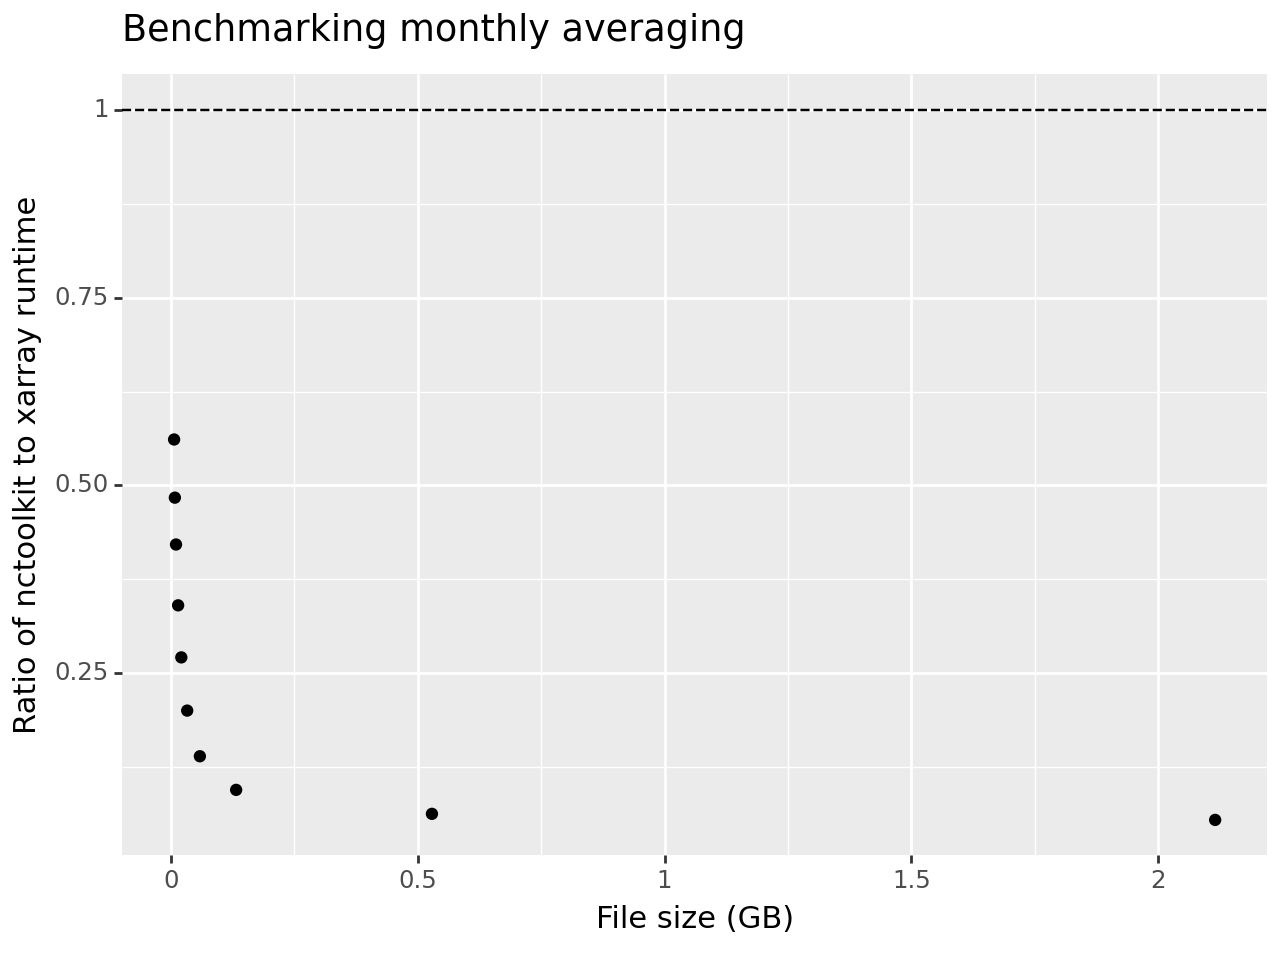

<Figure Size: (640 x 480)>

In [8]:
xr_times = []
nc_times = []
ff_sizes = []
from tqdm import tqdm
import pandas as pd
bins = list(1/ np.arange(1, 3))
bins += list(np.arange(2, 10))

for i in tqdm(range(len(bins))):

    ds_start = nc.open_data(ff_orig)
    bin_res = bins[i]
    ds_start.to_latlon(lon = [-180 + bin_res/2, 180 - bin_res/2], lat = [-90 + bin_res/2, 90 - bin_res/2], res = bin_res)
    ds_start.run()
    ff = ds_start[0]

    # ff = random.sample(paths, 1)[0]
    ff_sizes.append(os.path.getsize(ff))
    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = xr.open_dataset(ff1)
    ds = ds.groupby("time.month").mean()
    ds.to_netcdf("test.nc")
    t_xarray = time.time() - t
    xr_times.append(t_xarray)
    os.remove("test.nc")
    os.remove(ff1)

    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = nc.open_data(ff1, checks = False)
    ds.tmean("month")
    ds.to_nc("test.nc", zip = False)
    t_nctoolkit = time.time() - t
    os.remove("test.nc")
    os.remove(ff1)
    nc_times.append(t_nctoolkit)
    clear_output()

df = (
    pd.DataFrame({"f_size": ff_sizes, "xr_time": xr_times, "nc_time": nc_times})
    .assign(ratio = lambda x: x.nc_time/x.xr_time)
    # convert f_size to gb
    .assign(f_size = lambda x: x.f_size/1e9)
)

(
    ggplot(df, aes(x = "f_size", y = "ratio")) +
    geom_point()+
    labs(x = "File size (GB)", y = "Ratio of nctoolkit to xarray runtime")+
    geom_hline(yintercept = 1, linetype = "dashed")+
    labs(title = "Benchmarking monthly averaging")
)



# Benchmark temporal minimum

## Benchmark temporal maximum

100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


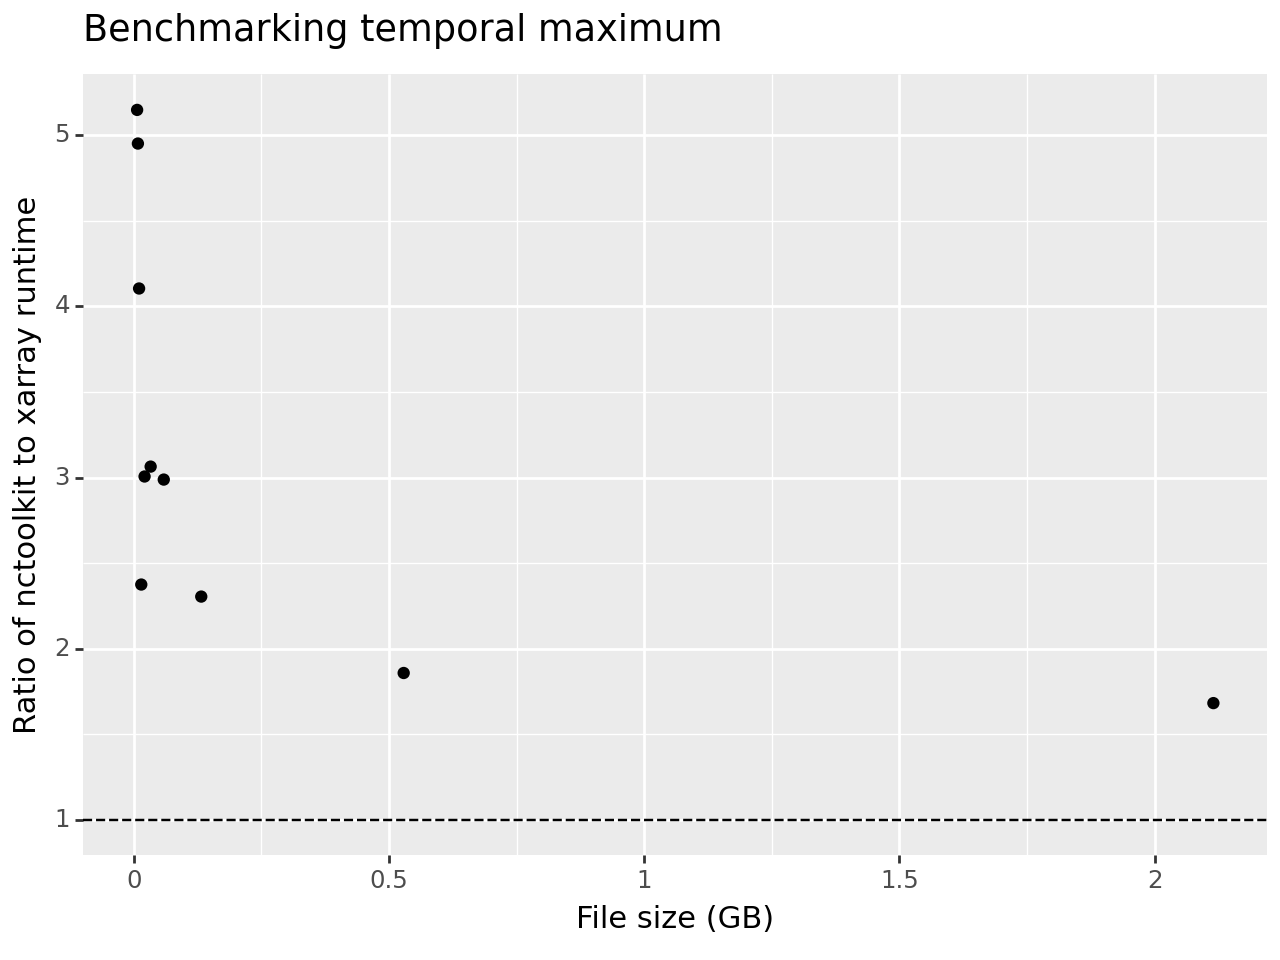

<Figure Size: (640 x 480)>

In [9]:
xr_times = []
nc_times = []
ff_sizes = []
from tqdm import tqdm
import pandas as pd
bins = list(1/ np.arange(1, 3))
bins += list(np.arange(2, 10))

for i in tqdm(range(len(bins))):

    ds_start = nc.open_data(ff_orig)
    bin_res = bins[i]
    ds_start.to_latlon(lon = [-180 + bin_res/2, 180 - bin_res/2], lat = [-90 + bin_res/2, 90 - bin_res/2], res = bin_res)
    ds_start.run()
    ff = ds_start[0]

    ff_sizes.append(os.path.getsize(ff))
    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = xr.open_dataset(ff1)
    ds = ds.max("time")
    ds.to_netcdf("test.nc")
    t_xarray = time.time() - t
    xr_times.append(t_xarray)
    os.remove("test.nc")
    os.remove(ff1)

    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = nc.open_data(ff1, checks = False)
    ds.tmax()
    ds.to_nc("test.nc", zip = False)
    t_nctoolkit = time.time() - t
    os.remove("test.nc")
    os.remove(ff1)
    nc_times.append(t_nctoolkit)
    clear_output()

df = (
    pd.DataFrame({"f_size": ff_sizes, "xr_time": xr_times, "nc_time": nc_times})
    .assign(ratio = lambda x: x.nc_time/x.xr_time)
    # convert f_size to gb
    .assign(f_size = lambda x: x.f_size/1e9)
)

(
    ggplot(df, aes(x = "f_size", y = "ratio")) +
    geom_point()+
    labs(x = "File size (GB)", y = "Ratio of nctoolkit to xarray runtime")+
    geom_hline(yintercept = 1, linetype = "dashed")+
    labs(title = "Benchmarking temporal maximum")
)



# Benchmark spatial averaging

In [10]:
xr_times = []
nc_times = []
ff_sizes = []
from tqdm import tqdm
import pandas as pd
bins = list(1/ np.arange(1, 4))
bins += list(np.arange(2, 10))

for i in tqdm(range(len(bins))):

    ds_start = nc.open_data(ff_orig)
    bin_res = bins[i]
    ds_start.to_latlon(lon = [-180 + bin_res/2, 180 - bin_res/2], lat = [-90 + bin_res/2, 90 - bin_res/2], res = bin_res)
    ds_start.run()
    ff = ds_start[0]

    ff_sizes.append(os.path.getsize(ff))
    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = xr.open_dataset(ff1)
    ds = ds[variable]
    ds = calc_spatial_mean(ds)
    ds.to_netcdf("test.nc")
    t_xarray = time.time() - t
    xr_times.append(t_xarray)
    os.remove("test.nc")
    os.remove(ff1)

    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = nc.open_data(ff1, checks = False)
    ds.subset(variable = variable) 
    ds.spatial_mean()
    ds.to_nc("test.nc", zip = False)
    t_nctoolkit = time.time() - t
    os.remove("test.nc")
    os.remove(ff1)
    nc_times.append(t_nctoolkit)
    clear_output()

df = (
    pd.DataFrame({"f_size": ff_sizes, "xr_time": xr_times, "nc_time": nc_times})
    .assign(ratio = lambda x: x.nc_time/x.xr_time)
    # convert f_size to gb
    .assign(f_size = lambda x: x.f_size/1e9)
    .query("f_size > 0.010")
)

(
    ggplot(df, aes(x = "f_size", y = "ratio")) +
    geom_point()+
    labs(x = "File size (GB)", y = "Ratio of nctoolkit to xarray runtime")+
    geom_hline(yintercept = 1, linetype = "dashed")+
    labs(title = "Benchmarking spatial mean")
)



100%|██████████| 11/11 [01:14<00:00,  6.73s/it]


<Figure Size: (640 x 480)>

## Rolling mean

In [11]:
xr_times = []
nc_times = []
ff_sizes = []
from tqdm import tqdm
import pandas as pd
bins = list(1/ np.arange(1, 3))
bins += list(np.arange(2, 10))

for i in tqdm(range(len(bins))):

    ds_start = nc.open_data(ff_orig)
    bin_res = bins[i]
    ds_start.to_latlon(lon = [-180 + bin_res/2, 180 - bin_res/2], lat = [-90 + bin_res/2, 90 - bin_res/2], res = bin_res)
    ds_start.run()
    ff = ds_start[0]

    ff_sizes.append(os.path.getsize(ff))
    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = xr.open_dataset(ff1)
    ds = ds.rolling(time = 12).mean()
    ds.to_netcdf("test.nc")
    t_xarray = time.time() - t
    xr_times.append(t_xarray)
    os.remove("test.nc")
    os.remove(ff1)

    ff1 = random_path()
    shutil.copy(ff, ff1) 

    t = time.time()
    ds = nc.open_data(ff1, checks = False)
    ds.rolling_mean(12)
    ds.to_nc("test.nc", zip = False)
    t_nctoolkit = time.time() - t
    os.remove("test.nc")
    os.remove(ff1)
    nc_times.append(t_nctoolkit)
    clear_output()

df = (
    pd.DataFrame({"f_size": ff_sizes, "xr_time": xr_times, "nc_time": nc_times})
    .assign(ratio = lambda x: x.nc_time/x.xr_time)
    # convert f_size to gb
    .assign(f_size = lambda x: x.f_size/1e9)
)

(
    ggplot(df, aes(x = "f_size", y = "ratio")) +
    geom_point()+
    labs(x = "File size (GB)", y = "Ratio of nctoolkit to xarray runtime")+
    geom_hline(yintercept = 1, linetype = "dashed")+
    labs(title = "Benchmarking rolling mean")
)



100%|██████████| 10/10 [02:23<00:00, 14.31s/it]


<Figure Size: (640 x 480)>